# Analyzing Scenario Results

In [1]:
from datetime import datetime, timedelta
from src.configs import (
    ADDRESSES,
    TOKEN_DTOs,
    get_scenario_config,
    get_price_config,
    CRVUSD_DTO,
)
import pickle
import pandas as pd
import json
import os
import numpy as np
from crvusdsim.pool import get  # type: ignore
from copy import deepcopy
from src.sim.scenario import Scenario
from src.configs.shocks import DEBT, LIQUIDITY, VOL, MU, JUMP, NEUTRAL, ADVERSE, SEVERE

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

%load_ext autoreload
%autoreload 2

In [2]:
def get_results():
    """
    Get all the result objects in the result directory.
    """
    results = []
    dir_ = f"../results/"
    scenario_dirs = [os.path.join(dir_, f) for f in os.listdir(dir_)]
    for scenario_dir in scenario_dirs:
        results_per_scenario = []
        files = [os.path.join(scenario_dir, f) for f in os.listdir(scenario_dir)]
        for file in files:
            with open(file, "rb") as f:
                result = pickle.load(f)
            results_per_scenario.append(result)
        results.extend(results_per_scenario)
    return results


def get_tags(result):
    shocks = result.metadata["template"].config["shocks"]
    tags = {
        MU: None,
        VOL: None,
        JUMP: None,
        DEBT: None,
        LIQUIDITY: None,
    }
    for shock in shocks:
        if shock["type"] == DEBT:
            tags[DEBT] = shock["tag"]
        elif shock["type"] == LIQUIDITY:
            tags[LIQUIDITY] = shock["tag"]
        elif shock["type"] == VOL:
            tags[VOL] = shock["tag"]
        elif shock["type"] == MU:
            tags[MU] = shock["tag"]
        elif shock["type"] == JUMP:
            tags[JUMP] = shock["tag"]

    for tag in tags:
        if tags[tag] is None:
            tags[tag] = NEUTRAL

    return tags


def compare(results) -> pd.DataFrame:
    stats = []
    for i, result in enumerate(results):
        starting_debt = (
            sum([datum.df["Total Debt"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )
        starting_crvusd_liquidity = (
            sum([datum.df["Total crvUSD Liquidity"].iloc[0] for datum in result.data])
            / len(result.data)
            / 1e6
        )

        stats_per_run = {
            "Name": result.metadata["template"].name,
            f"Starting Debt (Mns)": starting_debt,
            f"Starting Debt:Liquidity Ratio": starting_debt / starting_crvusd_liquidity,
        }

        tags = get_tags(result)
        stats_per_run.update(tags)

        for metric in [
            "Bad Debt Pct",
            "Debt Liquidated Pct",
            "Soft Liquidation Loss Pct",
            # "Borrower Loss Pct",
            # "Aggregator Price",
            "Worst Oracle Error Pct",
            "Pk Debt",
        ]:
            # stats_per_run[f"{metric} Mean"] = result.summary[f"{metric} Max"].mean()
            stats_per_run[f"{metric} Median"] = result.summary[f"{metric} Max"].median()
            # stats_per_run[f"{metric} p95"] = result.summary[f"{metric} Max"].quantile(
            #     0.95
            # )
            stats_per_run[f"{metric} p99"] = result.summary[f"{metric} Max"].quantile(
                0.99
            )
        stats.append(stats_per_run)
    df = pd.DataFrame(stats).astype(float, errors="ignore").round(3)
    df.sort_values(["Name"])
    return df

In [3]:
results = get_results()

In [130]:
df = compare(results)
df

,Name,Starting Debt (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99,Pk Debt Median,Pk Debt p99
0,Adverse crvUSD Liquidity,109.930,2.972,neutral,neutral,neutral,neutral,adverse,0.000,0.000,0.000,0.000,0.003,0.075,0.123,0.176,211376.197,2.325105e+06
1,Adverse crvUSD Liquidity,109.245,2.966,neutral,neutral,neutral,neutral,adverse,0.000,0.000,0.000,0.000,0.002,0.110,0.122,0.188,211376.197,4.005711e+06
2,Adverse crvUSD Liquidity,109.902,2.997,neutral,neutral,neutral,neutral,adverse,0.000,0.000,0.000,0.025,0.003,0.092,0.122,0.170,211376.197,9.018932e+06
3,Adverse crvUSD Liquidity,110.288,2.996,neutral,neutral,neutral,neutral,adverse,0.000,0.000,0.000,0.000,0.003,0.115,0.136,0.176,211376.197,8.474577e+06
4,Adverse crvUSD Liquidity,109.988,2.969,neutral,neutral,neutral,neutral,adverse,0.000,0.000,0.000,0.000,0.004,0.098,0.117,0.160,211376.197,7.720862e+06
5,Adverse vol,109.447,2.306,neutral,adverse,neutral,neutral,neutral,0.000,0.080,0.137,3.121,0.014,0.129,0.127,0.182,211376.197,6.370173e+06
6,Adverse vol,109.755,2.314,neutral,adverse,neutral,neutral,neutral,0.000,0.218,0.100,3.228,0.011,0.204,0.119,0.171,211376.197,2.579548e+06
7,Adverse vol,109.859,2.326,neutral,adverse,neutral,neutral,neutral,0.000,0.057,0.124,4.693,0.013,0.130,0.124,0.180,211376.197,1.454765e+07
8,Adverse vol,110.430,2.337,neutral,adverse,neutral,neutral,neutral,0.000,0.029,0.097,6.269,0.012,0.199,0.117,0.159,211376.197,7.480568e+06
9,Adverse vol,109.866,2.311,neutral,adverse,neutral,neutral,neutral,0.000,0.176,0.152,4.531,0.014,0.150,0.123,0.193,211376.197,8.593301e+06


In [107]:
grouped = (
    df.groupby(["Name", MU, VOL, DEBT, LIQUIDITY, JUMP])
    .mean()
    .round(3)
    .sort_index()
    .reset_index()
    .set_index("Name")
)
grouped

,mu,vol,debt,liquidity,jump,Starting Debt (Mns),Starting Debt:Liquidity Ratio,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
Name,,,,,,,,,,,,,,,
Adverse Growth,neutral,neutral,adverse,neutral,neutral,163.335,2.313,0.000,0.000,0.000,0.001,0.003,0.098,0.124,0.174
Adverse crvUSD Liquidity,neutral,neutral,neutral,adverse,neutral,109.871,2.980,0.000,0.000,0.000,0.005,0.003,0.098,0.124,0.174
Adverse depeg,neutral,neutral,neutral,neutral,adverse,110.248,2.321,0.000,1.304,0.245,8.220,0.038,1.155,11.316,18.661
Adverse flash crash,neutral,neutral,neutral,neutral,adverse,109.946,2.316,0.000,0.888,0.000,1.824,0.008,0.144,0.143,0.180
Adverse flash crash and adverse crvUSD liquidity,neutral,neutral,neutral,adverse,adverse,109.957,2.985,0.000,0.742,0.000,2.645,0.008,0.153,0.148,0.194
Adverse flash crash and adverse growth,neutral,neutral,adverse,neutral,adverse,163.054,2.315,0.000,0.618,0.000,1.796,0.009,0.115,0.124,0.176
Adverse flash crash and severe crvUSD liquidity,neutral,neutral,neutral,severe,adverse,109.831,5.055,0.000,0.625,0.000,1.489,0.008,0.144,0.123,0.170
Adverse flash crash and severe growth,neutral,neutral,severe,neutral,adverse,570.576,2.328,0.013,0.795,0.016,1.665,0.015,0.100,0.142,0.184
Adverse vol,neutral,adverse,neutral,neutral,neutral,109.871,2.319,0.000,0.112,0.122,4.368,0.013,0.162,0.122,0.177


In [110]:
grouped[grouped[LIQUIDITY] == NEUTRAL]

,mu,vol,debt,liquidity,jump,Starting Debt (Mns),Starting Debt:Liquidity Ratio,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
Name,,,,,,,,,,,,,,,
Adverse Growth,neutral,neutral,adverse,neutral,neutral,163.335,2.313,0.000,0.000,0.000,0.001,0.003,0.098,0.124,0.174
Adverse depeg,neutral,neutral,neutral,neutral,adverse,110.248,2.321,0.000,1.304,0.245,8.220,0.038,1.155,11.316,18.661
Adverse flash crash,neutral,neutral,neutral,neutral,adverse,109.946,2.316,0.000,0.888,0.000,1.824,0.008,0.144,0.143,0.180
Adverse flash crash and adverse growth,neutral,neutral,adverse,neutral,adverse,163.054,2.315,0.000,0.618,0.000,1.796,0.009,0.115,0.124,0.176
Adverse flash crash and severe growth,neutral,neutral,severe,neutral,adverse,570.576,2.328,0.013,0.795,0.016,1.665,0.015,0.100,0.142,0.184
Adverse vol,neutral,adverse,neutral,neutral,neutral,109.871,2.319,0.000,0.112,0.122,4.368,0.013,0.162,0.122,0.177
Baseline,neutral,neutral,neutral,neutral,neutral,109.775,2.311,0.000,0.000,0.000,0.005,0.003,0.089,0.167,0.202
Severe Growth,neutral,neutral,severe,neutral,neutral,569.300,2.318,0.000,0.002,0.000,0.023,0.007,0.045,0.171,0.207
Severe flash crash,neutral,neutral,neutral,neutral,severe,109.716,2.312,0.467,8.053,0.219,10.484,0.072,0.934,0.122,0.178


In [111]:
grouped[grouped[LIQUIDITY] == ADVERSE]

,mu,vol,debt,liquidity,jump,Starting Debt (Mns),Starting Debt:Liquidity Ratio,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
Name,,,,,,,,,,,,,,,
Adverse crvUSD Liquidity,neutral,neutral,neutral,adverse,neutral,109.871,2.980,0.0,0.000,0.000,0.005,0.003,0.098,0.124,0.174
Adverse flash crash and adverse crvUSD liquidity,neutral,neutral,neutral,adverse,adverse,109.957,2.985,0.0,0.742,0.000,2.645,0.008,0.153,0.148,0.194
Severe vol and adverse crvUSD liquidity,neutral,severe,neutral,adverse,neutral,109.967,2.980,0.0,0.625,0.551,9.024,0.028,0.257,0.120,0.166


In [112]:
grouped[grouped[LIQUIDITY] == SEVERE]

,mu,vol,debt,liquidity,jump,Starting Debt (Mns),Starting Debt:Liquidity Ratio,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
Name,,,,,,,,,,,,,,,
Adverse flash crash and severe crvUSD liquidity,neutral,neutral,neutral,severe,adverse,109.831,5.055,0.0,0.625,0.00,1.489,0.008,0.144,0.123,0.170
Severe crvUSD Liquidity,neutral,neutral,neutral,severe,neutral,109.991,5.022,0.0,0.000,0.00,0.000,0.003,0.080,0.152,0.188
Severe vol and severe crvUSD liquidity,neutral,severe,neutral,severe,neutral,110.052,5.021,0.0,1.103,0.52,11.184,0.032,0.267,0.166,0.213


In [43]:
grouped[grouped[VOL] == ADVERSE]

,mu,vol,debt,liquidity,jump,Starting Debt (Mns),Starting Debt:Liquidity Ratio,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
Name,,,,,,,,,,,,,,,
Adverse vol,neutral,adverse,neutral,neutral,neutral,109.871,2.319,0.0,0.112,0.122,4.368,0.013,0.162,0.122,0.177


In [51]:
df[(df[VOL] == SEVERE) & (df[DEBT].isin([ADVERSE, SEVERE]))]

,Name,Starting Debt (Mns),Starting Debt:Liquidity Ratio,mu,vol,jump,debt,liquidity,Bad Debt Pct Median,Bad Debt Pct p99,Debt Liquidated Pct Median,Debt Liquidated Pct p99,Soft Liquidation Loss Pct Median,Soft Liquidation Loss Pct p99,Worst Oracle Error Pct Median,Worst Oracle Error Pct p99
15,Severe vol and adverse growth,161.884,2.291,neutral,severe,neutral,adverse,neutral,0.000,0.232,0.569,8.846,0.038,0.240,0.119,0.182
16,Severe vol and adverse growth,163.217,2.314,neutral,severe,neutral,adverse,neutral,0.000,0.562,0.618,7.175,0.028,0.285,0.119,0.171
17,Severe vol and adverse growth,163.584,2.330,neutral,severe,neutral,adverse,neutral,0.000,1.645,0.739,9.077,0.039,0.256,0.119,0.182
18,Severe vol and adverse growth,162.289,2.298,neutral,severe,neutral,adverse,neutral,0.000,0.088,0.581,8.680,0.030,0.236,0.121,0.170
19,Severe vol and adverse growth,162.287,2.298,neutral,severe,neutral,adverse,neutral,0.000,3.750,0.856,11.900,0.045,0.314,0.141,0.177
85,Severe vol and severe growth,570.449,2.318,neutral,severe,neutral,severe,neutral,0.008,0.547,1.147,8.658,0.050,0.256,0.120,0.189
86,Severe vol and severe growth,569.408,2.321,neutral,severe,neutral,severe,neutral,0.013,0.814,1.583,5.867,0.056,0.201,0.127,0.173
87,Severe vol and severe growth,570.892,2.337,neutral,severe,neutral,severe,neutral,0.011,0.890,1.192,5.755,0.052,0.180,0.125,0.185
88,Severe vol and severe growth,569.799,2.324,neutral,severe,neutral,severe,neutral,0.011,0.209,1.399,5.152,0.057,0.174,0.365,0.374
89,Severe vol and severe growth,567.909,2.310,neutral,severe,neutral,severe,neutral,0.004,0.431,1.022,7.939,0.040,0.275,0.122,0.173


0.0
0.6332948054522237


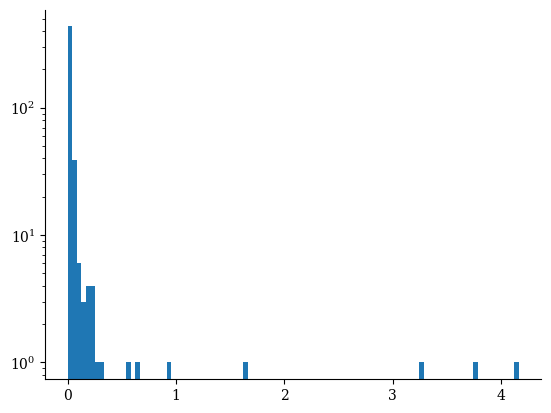

0.008923943675422472
0.8081962203756399


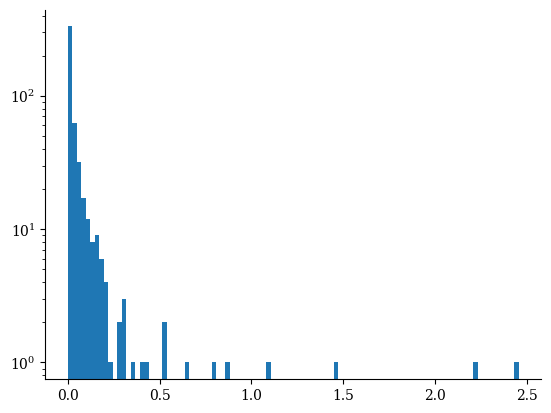

In [96]:
import matplotlib.pyplot as plt


amts = []
for result in results:
    if result.metadata["scenario"] == "severe vol and adverse growth":
        amts.extend(result.summary["Bad Debt Pct Max"].values)

amts = np.array(amts)
print(np.quantile(amts, 0.5))
print(np.quantile(amts, 0.99))
plt.hist(amts, bins=100)
plt.yscale("log")
plt.show()

amts = []
for result in results:
    if result.metadata["scenario"] == "severe vol and severe growth":
        amts.extend(result.summary["Bad Debt Pct Max"].values)

amts = np.array(amts)
print(np.quantile(amts, 0.5))
print(np.quantile(amts, 0.99))
plt.hist(amts, bins=100)
plt.yscale("log")
plt.show()

151614427.36371827
573539716.9204503


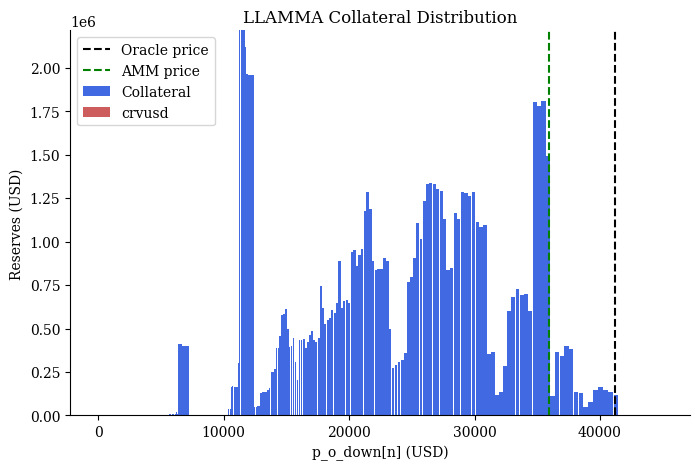

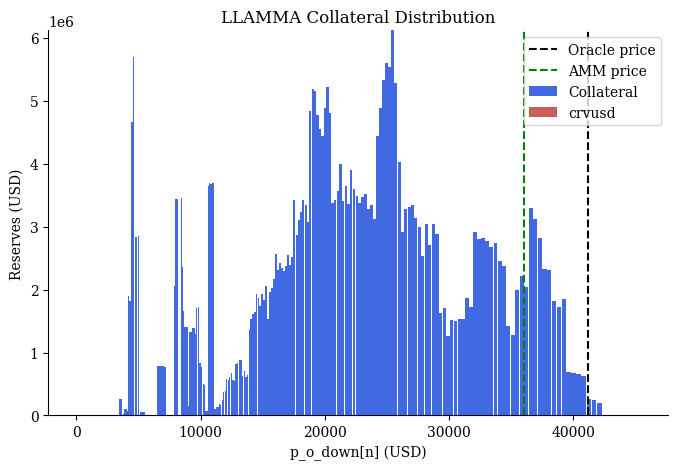

In [65]:
from src.plotting.sim import plot_reserves

for result in results:
    if result.metadata["scenario"] == "severe vol and adverse growth":
        scenario = deepcopy(result.metadata["template"])
        scenario.prepare_for_run()
        print(scenario.total_debt / 1e18)
        plot_reserves(scenario.llammas[0])
        break

for result in results:
    if result.metadata["scenario"] == "severe vol and severe growth":
        scenario = deepcopy(result.metadata["template"])
        scenario.prepare_for_run()
        print(scenario.total_debt / 1e18)
        plot_reserves(scenario.llammas[0])
        break

KeyError: 'PK Debt Max'